# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticLCS folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/EllipticLCS")

CPU times: user 481 µs, sys: 458 µs, total: 939 µs
Wall time: 473 µs


# Overview

In the following notebok we visualize elliptic LCS in the Agulhas region from the AVISO dataset using the Polar Rotation Angle. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'
<br />
2. Define computational parameters (such as the number of cores) and variables
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data using a cubic spline interpolation
 <br />
5. Elliptic LCS:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary meshgrid. 
   
    * Compute Cauchy Green strain tensor $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $ from $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $. 
   
    * Compute eigenvector $ \xi_{1,2}(\mathbf{x}_0) $ of the Cauchy Green strain tensor $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $.
    
    * Elliptic LCSs are closed null geodesics of the one-parameter family of Lorentzian metrics:
    
    \begin{equation}
    \mathrm{A_{\lambda}(\mathbf{x},t)} = \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) - \lambda^2\mathbf{I}
    \end{equation}
    
    We denote:
    \begin{equation}
    \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) = \begin{pmatrix} C^{11} && C^{12} \\ C^{12} && C^{22}\end{pmatrix}
    \end{equation}
    
    Closed null geodesics are closed curves of the system of ODE:
    
    \begin{align*}
    \dfrac{d \mathbf{x}}{ds} &= \mathbf{e}_{\phi}(s) = \begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix} \\
    \dfrac{d \phi}{ds} &= - \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A(\mathbf{x}) \mathbf{e}_{\phi}(s)}, 
    \end{align*} where $ R = \begin{pmatrix} 0 && -1 \\ 1 && 0\end{pmatrix} $
    $  \dfrac{d \phi}{ds} $ depends both on $ \mathbf{x} $ and on $ \phi $ and can be evualated through interpolation by first computing $ \nabla_x A(\mathbf{x}) = \nabla_x C_{t_0}^{t_N}(\mathbf{x}) $ over the meshgrid. 
    
    It holds:
    \begin{equation}
    \dfrac{d \phi}{ds} = - \dfrac{\cos^2(\phi)[C_x^{11}(\mathbf{x})\cos(\phi)+C_y^{11}(\mathbf{x})\sin(\phi)]+[C_x^{12}(\mathbf{x})\cos(\phi)+C_y^{11}(\mathbf{x})\sin(\phi)]\sin(2\phi)+\sin^2(\phi)[C_x^{22}(\mathbf{x})\cos(\phi)+C_y^{22}(\mathbf{x})\sin(\phi)}{\sin(2\phi)[C^{22}(\mathbf{x})-C^{11}(\mathbf{x})]+2\cos(2\phi)C^{12}(\mathbf{x})}
    \end{equation}
    
       The set of initial conditions is given by:
    \begin{equation}
    (\mathbf{x}_0, \phi_0)_{\mu} = \lbrace (\mathbf{x}_0(\lambda, \phi = 0), 0) \in V: C^{11}(\mathbf{x}, t)- \lambda^2 = 0 \rbrace
    \end{equation}
    
    Furthermore the domain of existence of the ODE is restricted to points $ \mathbf{x}, \phi $ where:
    
    \begin{equation}
    \sin(2\phi)[C^{22}(\mathbf{x})-C^{11}(\mathbf{x})]+2\cos(2\phi)C^{12}(\mathbf{x}) \neq 0
    \end{equation}

# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

CPU times: user 152 ms, sys: 51.7 ms, total: 203 ms
Wall time: 302 ms


# Data/Parameters for Dynamical System

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 18

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## meshgrid
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-Temporal Domain

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 30

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# domain boundary (in degrees)
xmin = -2
xmax = 0.5
ymin = -30.5
ymax = -28

# make sure that the spatio-temporal you defined are within the domain of the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 1.49 ms, sys: 1.65 ms, total: 3.13 ms
Wall time: 9.81 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 121 ms, sys: 31.5 ms, total: 152 ms
Wall time: 228 ms


# Cauchy Green (CG) strain tensor

The Cauchy Green strain tensor $ C_{t_0}^t(\mathbf{x}) $ is computing by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{10}, \dfrac{1}{100}] $. The computations are parallelized.

In [6]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import gradient of velocity function
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import Rate of Strain function
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/10, 1/100]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 5), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 5)]

def parallel_C(i):
    
    C_parallel = np.zeros((X_domain.shape[1], 2, 2))
    
    for j in range(C_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # Compute gradient of flowmap
        gradFmap = gradient_flowmap(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
        # gradFmap has shape (2, 2, len(time)) --> we need gradient of flow map from t0 to tN
        gradFmap_t0_tN = gradFmap[:,:,-1]
        
        # Compute CG tensor
        C_parallel[j, :, :] = CauchyGreen(gradFmap_t0_tN)
    
    return C_parallel

C = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_C)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/252 [00:00<?, ?it/s]

CPU times: user 4.85 s, sys: 2.6 s, total: 7.45 s
Wall time: 9min 26s


# Compute Tensorfield

In [7]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute elements of CG tensor
C11 = np.nan_to_num(C[:,:,0,0], nan=0.0)
C12 = np.nan_to_num(C[:,:,0,1], nan=0.0)
C22 = np.nan_to_num(C[:,:,1,1], nan=0.0)
    
# Interpolate elements of CG tensor (per default: cubic)
interp_C11 = RBS(Y_domain[:,0], X_domain[0,:], C11)
interp_C12 = RBS(Y_domain[:,0], X_domain[0,:], C12)
interp_C22 = RBS(Y_domain[:,0], X_domain[0,:], C22)

# Initialize gradients of CG tensor
C11x = np.zeros((C.shape[0], C.shape[1]))*np.nan
C11y = np.zeros((C.shape[0], C.shape[1]))*np.nan
C12x = np.zeros((C.shape[0], C.shape[1]))*np.nan
C12y = np.zeros((C.shape[0], C.shape[1]))*np.nan
C22x = np.zeros((C.shape[0], C.shape[1]))*np.nan
C22y = np.zeros((C.shape[0], C.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]
rho_y = aux_grid[1]
        
#iterate over meshgrid to compute gradients of CG tensor
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        C11x[i, j] = (interp_C11(x[1], x[0]+rho_x)[0][0]-interp_C11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C11y[i, j] = (interp_C11(x[1]+rho_y, x[0])[0][0]-interp_C11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        C12x[i, j] = (interp_C12(x[1], x[0]+rho_x)[0][0]-interp_C12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C12y[i, j] = (interp_C12(x[1]+rho_y, x[0])[0][0]-interp_C12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        C22x[i, j] = (interp_C22(x[1], x[0]+rho_x)[0][0]-interp_C22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        C22y[i, j] = (interp_C22(x[1]+rho_y, x[0])[0][0]-interp_C22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [8]:
%%time
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant of phi_phrime (interp_phi_prime) 
# Interpolant indicating domain of existence (= denominator of phi_prime) (interp_DOE)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, C11, C12, C22, C11x, C11y, C12x, C12y, C22x, C22y)

CPU times: user 3.75 s, sys: 2.53 s, total: 6.28 s
Wall time: 2.82 s


# Find closed null-geodesics of $ C_{t_0}^{t_N}(\mathbf{x}_0) − \lambda^2 \mathbf{I} $

Elliptic LCSs are closed null geodesics of the one-parameter family of Lorentzian metrics $ C_{t_0}^{t_N}(\mathbf{x}_0) − \lambda^2 \mathbf{I} $. $ \lambda ∈ \mathbb{R} $ denotes the tangential stretch rate along an elliptic LCS. For perfectly coherent elliptic LCS it holds $ \lambda = 0 $.  

In [9]:
%%time
# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import _closed_null_geodesics

# extract elliptic OECS from closed null geodesics
from ipynb.fs.defs.elliptic_LCS import _elliptic_LCS

# define lambda range
lam_min = .9
lam_max = 1.1
n_lam = Ncores
lam_range = np.linspace(lam_min, lam_max, n_lam)

# parameter specifying sparsity of initial conditions. 
# Increasing this parameter reduces the number of initial conditions and thereby reduces the computational time involved.
# For maximal accuracy set sparse_ic = 1. This implies that we use the resolution of the meshgrid. 
# This value should always be at least 1.
sparse_ic = 1

# threshold distance between starting and return point of trajectory
d_threshold = dx/10

# compute elliptic LCS
def compute_ellipitic_LCS(lam):
    
    # Define list storing x, y coordinates of elliptic LCS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_null_geodesics, init_lam = _closed_null_geodesics(X_domain, Y_domain, lam, interp_phi_prime, d_threshold, C11, interp_DOE, sparse_ic)
    
    # Extract elliptic LCS
    x_elliptic, y_elliptic = _elliptic_LCS(closed_null_geodesics)
        
    return [x_elliptic, y_elliptic]
        
# conmpute elliptic LCS with parallel computing
Elliptic_LCS = Parallel(n_jobs=Ncores, verbose = 50)(delayed(compute_ellipitic_LCS)(lam) for lam in lam_range)

ModuleNotFoundError: No module named 'skimage'

NameError: name 'lam_range' is not defined

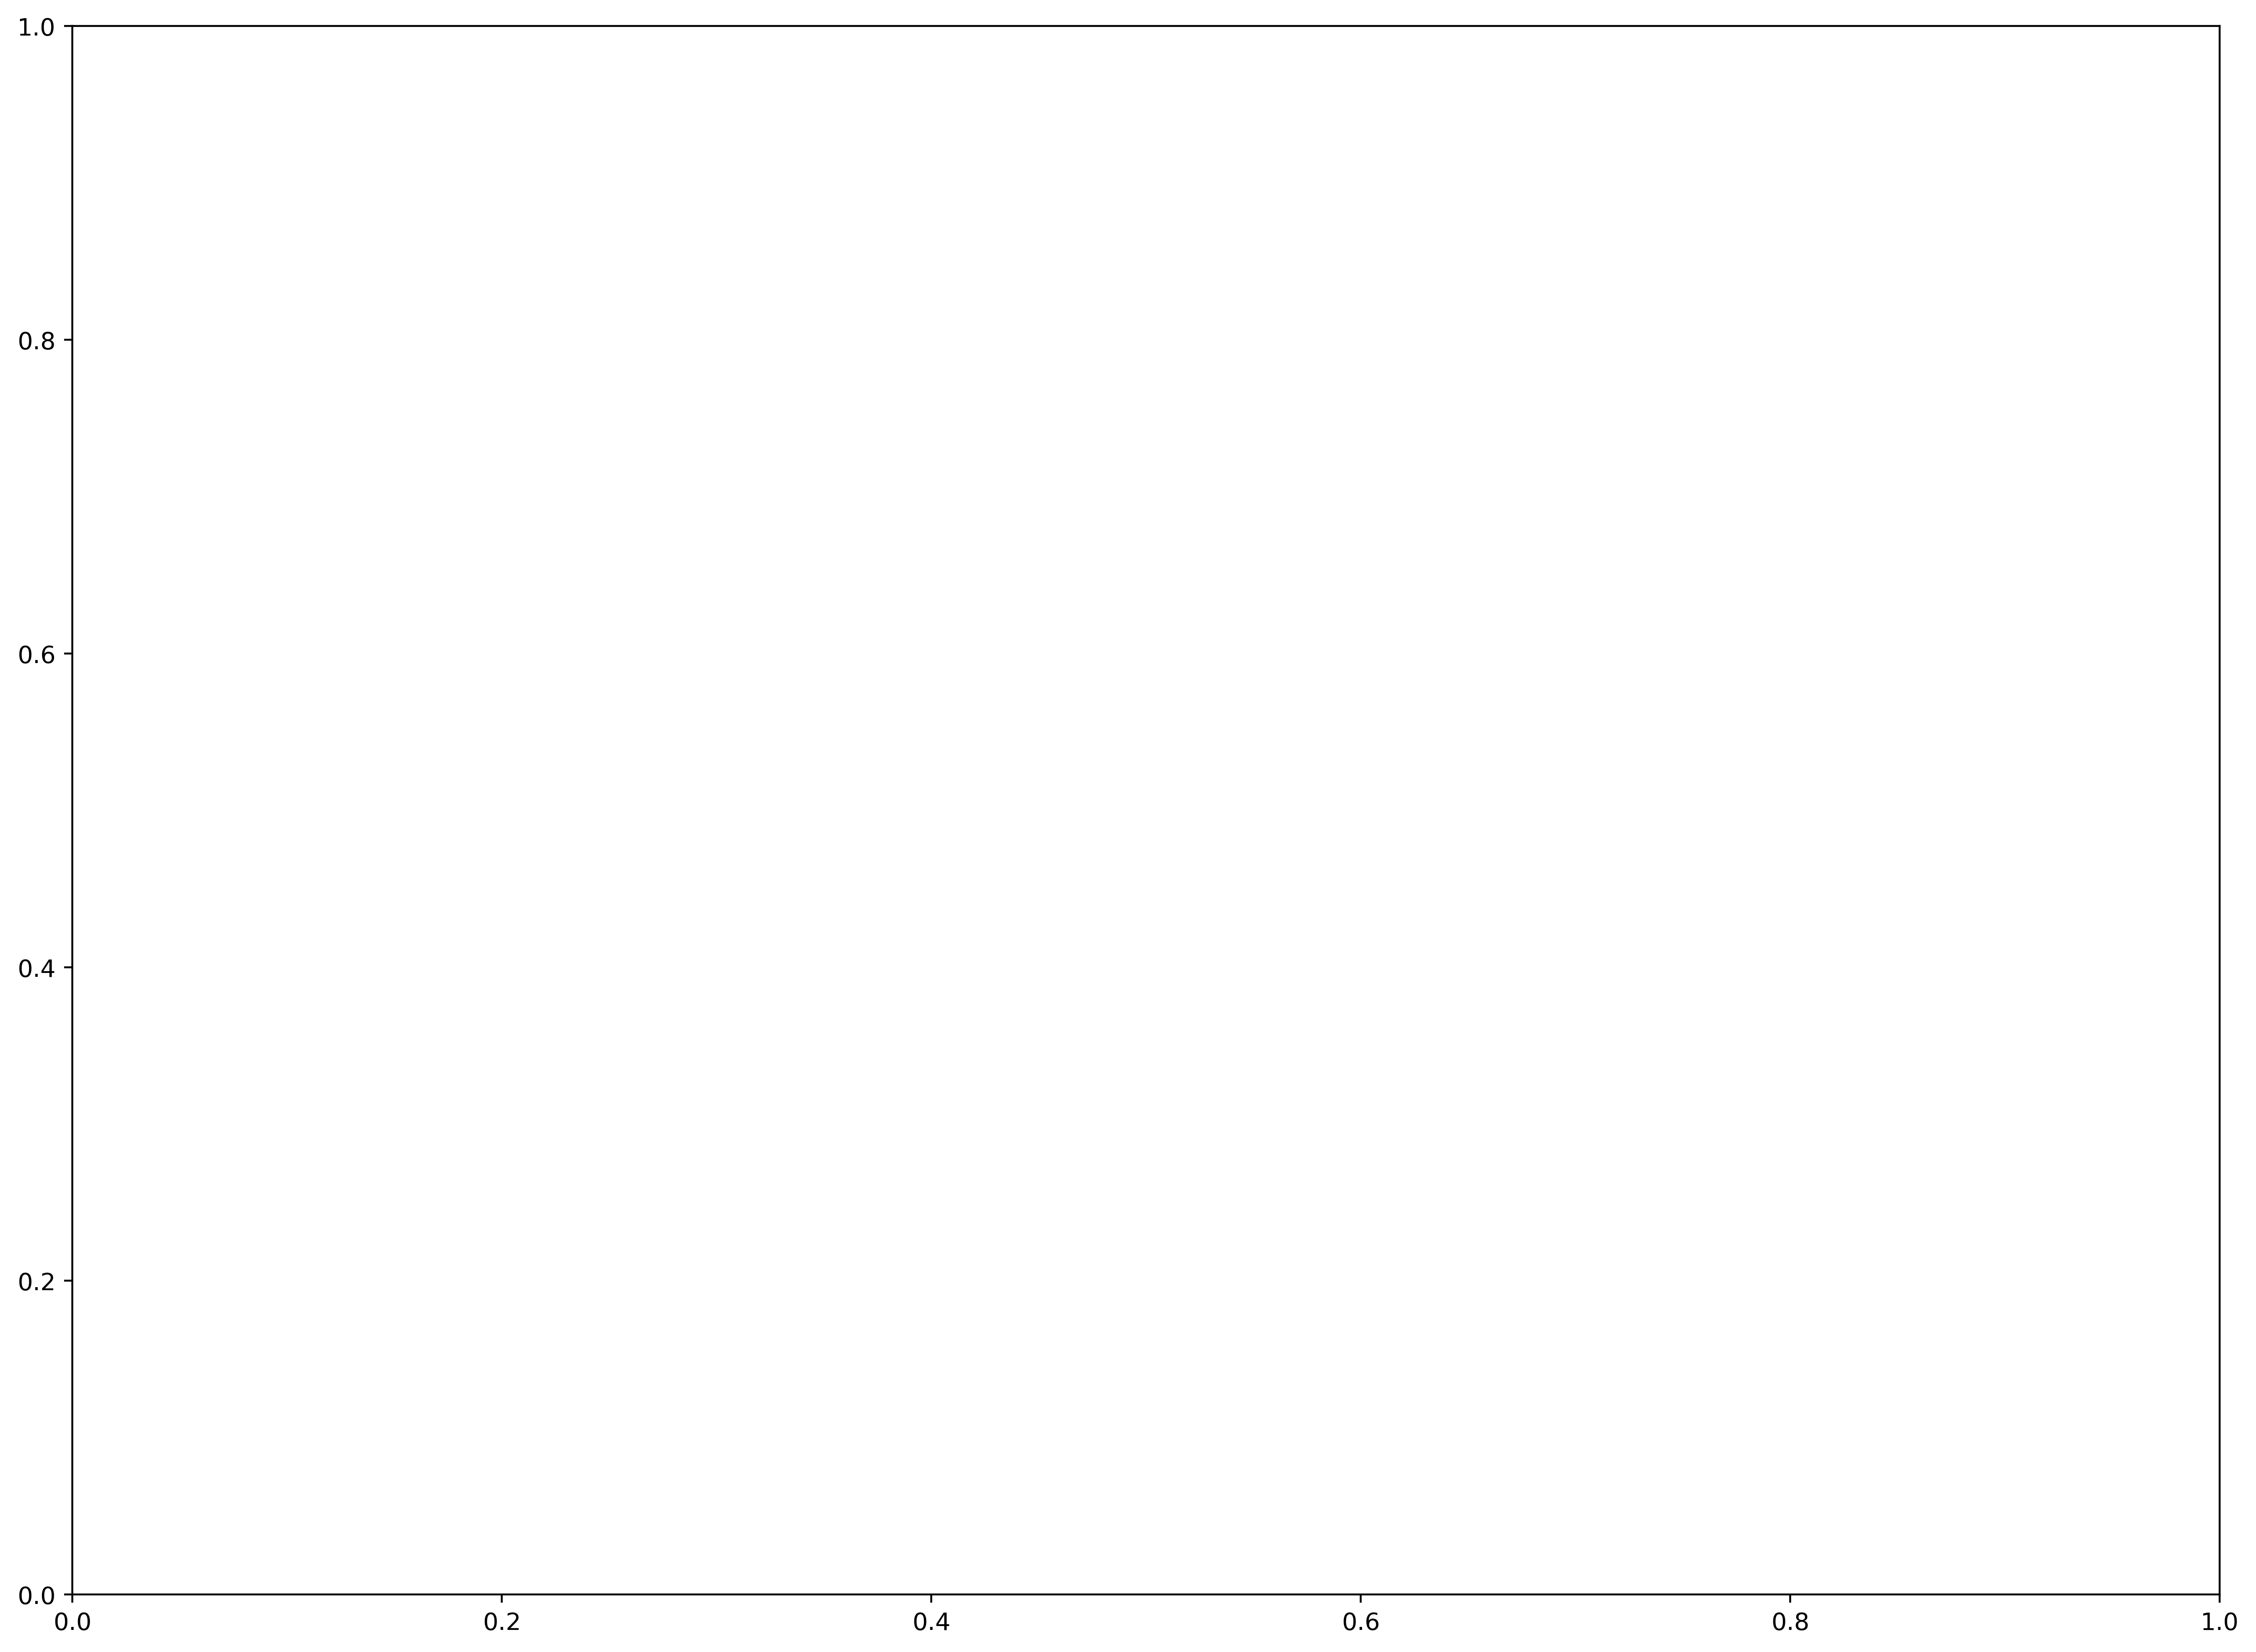

In [10]:
######################################## Plot elliptic LCS ########################################
# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (16, 12), dpi = 400)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=lam_range.min(), vmax=lam_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic LCS and plot
for i in range(len(Elliptic_LCS)):
    
    ax.scatter(lam_range[i], lam_range[i], s = 1, color=cmap.to_rgba(lam_range[i]))
    
    if Elliptic_LCS[i][0] is not None:
    
        for j in range(len(Elliptic_LCS[i][0])):
        
            if Elliptic_LCS[i][0][j] is not None:
        
                ax.plot(Elliptic_LCS[i][0][j], Elliptic_LCS[i][1][j], c=cmap.to_rgba(lam_range[i]), linewidth = 2)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[lam_range.min(), 0, lam_range.max()])
cbar.ax.set_ylabel(r'$ \lambda $', rotation = 0, fontsize = 16)

# Title
ax.set_title("Elliptic LCS", fontsize = 20)
plt.show();